## 이용량 결측치 처리

#### 노선 이용량을 활용성 지수로 변환
* 이용량 결측치 처리 과정에서 더 정확하게 분석하고 시각화한 후 예측
* 예측 성능 검증 진행

In [270]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [271]:
meta_data = pd.read_csv("../data/total_data.csv")
data = pd.read_csv("../data/여진_total_busdata.csv")

In [272]:
data["총인구수"] = meta_data["총인구수"]
data["노인(수)"] = meta_data["노인(수)"]
data["총인구수"] = data["총인구수"].apply(lambda x: int(x.replace(",", "")))
data["노인(수)"] = data["노인(수)"].apply(lambda x: int(x.replace(",", "")))

In [273]:
data.head()

,city_name,routeno,routetp,startnodenm,endnodenm,startvehicletime,endvehicletime,intervaltime,intervalsattime,intervalsuntime,...,노선정류장수,노선거리(km),굴곡도,start,end,total_operating_time,interval_avg,num_bus,총인구수,노인(수)
0,창원시,1,마을버스,신전,창원역,540.0,2210.0,40.0,40.0,40.0,...,105,55.9,2.0,340.0,1330.0,990.0,40.000000,24,1003731,276574
1,창원시,2,마을버스,유등,창원역,725.0,2150.0,170.0,170.0,170.0,...,83,53.5,1.7,445.0,1310.0,865.0,170.000000,5,1003731,276574
2,창원시,3,마을버스,상리,진영시외주차장,750.0,1655.0,220.0,220.0,220.0,...,74,43.8,2.6,470.0,1015.0,545.0,220.000000,2,1003731,276574
3,창원시,7,마을버스,창원역,자여입구,620.0,2310.0,11.0,15.0,15.0,...,35,21.1,1.0,380.0,1390.0,1010.0,12.142857,83,1003731,276574
4,창원시,8,마을버스,창원역,삼성창원병원종점(8),600.0,2240.0,17.0,17.0,17.0,...,39,8.8,1.8,360.0,1360.0,1000.0,17.000000,58,1003731,276574


In [274]:
data.columns

Index(['city_name', 'routeno', 'routetp', 'startnodenm', 'endnodenm',
       'startvehicletime', 'endvehicletime', 'intervaltime', 'intervalsattime',
       'intervalsuntime', 'usage', '노선정류장수', '노선거리(km)', '굴곡도', 'start', 'end',
       'total_operating_time', 'interval_avg', 'num_bus', '총인구수', '노인(수)'],
      dtype='object')

In [275]:
use_col = [ 
    'city_name',
    'routetp',
    '노선정류장수', 
    '노선거리(km)', 
    '굴곡도', 
    'total_operating_time', 
    'interval_avg', 
    'num_bus', 
    '총인구수', 
    '노인(수)', 
    'usage'
    ]

In [276]:
data = data[use_col]
data.head()

,city_name,routetp,노선정류장수,노선거리(km),굴곡도,total_operating_time,interval_avg,num_bus,총인구수,노인(수),usage
0,창원시,마을버스,105,55.9,2.0,990.0,40.000000,24,1003731,276574,33931.0
1,창원시,마을버스,83,53.5,1.7,865.0,170.000000,5,1003731,276574,2558.0
2,창원시,마을버스,74,43.8,2.6,545.0,220.000000,2,1003731,276574,299.0
3,창원시,마을버스,35,21.1,1.0,1010.0,12.142857,83,1003731,276574,63612.0
4,창원시,마을버스,39,8.8,1.8,1000.0,17.000000,58,1003731,276574,68306.0


In [277]:
data['routetp'].value_counts()

routetp
농어촌(일반)버스    1119
일반버스          988
지선버스          209
간선버스           88
좌석버스           58
마을버스           48
심야버스            2
급행버스            1
Name: count, dtype: int64

### split to train/valid/test set

In [278]:
from sklearn.model_selection import train_test_split
data_train = data[~data['usage'].isna()]
data_test = data[data['usage'].isna()]

train_set, valid_set = train_test_split(
    data_train, 
    test_size=0.2, 
    random_state=0
    )

In [279]:
train_set.isna().sum()
valid_set.isna().sum()

city_name               0
routetp                 0
노선정류장수                  0
노선거리(km)                0
굴곡도                     0
total_operating_time    0
interval_avg            0
num_bus                 0
총인구수                    0
노인(수)                   0
usage                   0
dtype: int64

### 범주형 변수 전처리 (One-hot Encoding)

#### routetp 

In [280]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

routetp = train_set['routetp']
v_routetp = valid_set['routetp']

# 전체 데이터에서 고유한 범주를 추출
all_routetp = np.unique(data['routetp'])

ohe = OneHotEncoder(
    categories=[all_routetp],
    sparse_output=False
    )
ohe.fit(routetp.values.reshape(-1,1))

dense_matrix_tr = ohe.transform(routetp.values.reshape(-1,1)) #train_set
dense_matrix_val = ohe.transform(v_routetp.values.reshape(-1,1)) #valid_set

In [281]:
ohe.categories_[0]

array(['간선버스', '급행버스', '농어촌(일반)버스', '마을버스', '심야버스', '일반버스', '좌석버스',
       '지선버스'], dtype=object)

In [282]:
# train_set, dense_matrix_tr 데이터 합치기

train_set = pd.concat([train_set.reset_index(drop=True),
pd.DataFrame(dense_matrix_tr, columns=ohe.categories_[0])],
axis=1)

In [283]:
# valid_set, dense_matrix_val 데이터 합치기

valid_set = pd.concat([valid_set.reset_index(drop=True), 
pd.DataFrame(dense_matrix_val, columns=ohe.categories_[0])], axis=1)

In [284]:
train_set.isna().sum()
valid_set.isna().sum()

city_name               0
routetp                 0
노선정류장수                  0
노선거리(km)                0
굴곡도                     0
total_operating_time    0
interval_avg            0
num_bus                 0
총인구수                    0
노인(수)                   0
usage                   0
간선버스                    0
급행버스                    0
농어촌(일반)버스               0
마을버스                    0
심야버스                    0
일반버스                    0
좌석버스                    0
지선버스                    0
dtype: int64

#### city_name

In [285]:
t_city = train_set['city_name']
v_city = valid_set['city_name']

# 전체 데이터에서 고유한 범주를 추출
all_city = np.unique(data['city_name'])

ohe = OneHotEncoder(
    categories=[all_city],
    sparse_output=False
    )
ohe.fit(t_city.values.reshape(-1,1))

dense_matrix_tr = ohe.transform(t_city.values.reshape(-1,1)) #train_set
dense_matrix_val = ohe.transform(v_city.values.reshape(-1,1)) #valid_set

In [286]:
ohe.categories_[0]

array(['거제시', '거창군', '고성군', '김해시', '남해군', '밀양시', '사천시', '산청군', '양산시',
       '의령군', '진주시', '창녕군', '창원시', '통영시', '하동군', '함안군', '함양군', '합천군'],
      dtype=object)

In [287]:
# train_set, dense_matrix_tr 데이터 합치기

train_set = pd.concat([train_set.reset_index(drop=True),
pd.DataFrame(dense_matrix_tr, columns=ohe.categories_[0])],
axis=1)

In [288]:
# valid_set, dense_matrix_val 데이터 합치기

valid_set = pd.concat([valid_set.reset_index(drop=True), 
pd.DataFrame(dense_matrix_val, columns=ohe.categories_[0])], axis=1)

In [289]:
train_set = train_set.drop(columns=['routetp','city_name'])
valid_set = valid_set.drop(columns=['routetp','city_name'])

In [290]:
train_set.isna().sum()
valid_set.isna().sum()

노선정류장수                  0
노선거리(km)                0
굴곡도                     0
total_operating_time    0
interval_avg            0
num_bus                 0
총인구수                    0
노인(수)                   0
usage                   0
간선버스                    0
급행버스                    0
농어촌(일반)버스               0
마을버스                    0
심야버스                    0
일반버스                    0
좌석버스                    0
지선버스                    0
거제시                     0
거창군                     0
고성군                     0
김해시                     0
남해군                     0
밀양시                     0
사천시                     0
산청군                     0
양산시                     0
의령군                     0
진주시                     0
창녕군                     0
창원시                     0
통영시                     0
하동군                     0
함안군                     0
함양군                     0
합천군                     0
dtype: int64

### 연속형 변수 전처리

In [291]:
col = [ 
    '노선정류장수', 
    '노선거리(km)', 
    '굴곡도', 
    'total_operating_time', 
    'interval_avg', 
    'num_bus', 
    '총인구수', 
    '노인(수)'
    ]

#### MICE 성능비교

In [294]:
#from impyute.imputation.cs import mice
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#### 정량적 (통계적 수치)

In [295]:
# rmse 함수
def imputer_validate_processor(
    train_set,
    valid_set, 
    y_name = "usage"
    ):
        
    y_valid_true = valid_set[y_name]
    valid_set["usage"] = np.array(np.nan)

    imputer = IterativeImputer(random_state=0)
    imputer.fit(train_set)
    imputer_valid_set = pd.DataFrame(imputer.transform(valid_set))

    imputer_valid_set.columns = valid_set.columns
    imputer_valid_set["usage"] = imputer_valid_set["usage"].round(0)

    return {"y_valid_true" : y_valid_true, 
            "y_valid_pred" : imputer_valid_set["usage"], 
            "rmse" : mean_squared_error(y_valid_true, imputer_valid_set["usage"], squared=False)}
    

In [ ]:
# minmaxscaler 사용
from sklearn.preprocessing import MinMaxScaler
minmax_t = train_set.copy()
minmax_v = valid_set.copy()

scaler = MinMaxScaler()
scaler.fit(train_set[col])

minmax_t[col] = scaler.transform(train_set[col])
minmax_v[col] = scaler.transform(valid_set[col])

result_minmax = imputer_validate_processor(minmax_t, minmax_v)
result_minmax["rmse"]

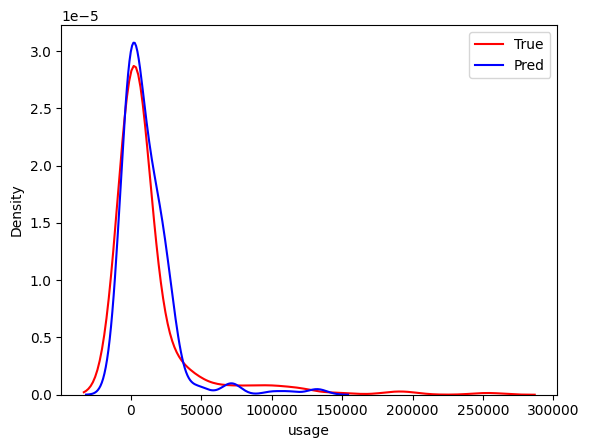

In [301]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.kdeplot(result_minmax["y_valid_true"], color="r", label="True")
sns.kdeplot(result_minmax["y_valid_pred"], color="b", label="Pred")
plt.legend()

In [302]:
# standardaxscaler 사용
from sklearn.preprocessing import StandardScaler
Standard_t = train_set.copy()
Standard_v = valid_set.copy()

scaler = StandardScaler()
scaler.fit(train_set[col])

Standard_t[col] = scaler.transform(train_set[col])
Standard_v[col] = scaler.transform(valid_set[col])

result_standard = imputer_validate_processor(Standard_t, Standard_v)
result_standard['rmse']

np.float64(23340.572851448083)

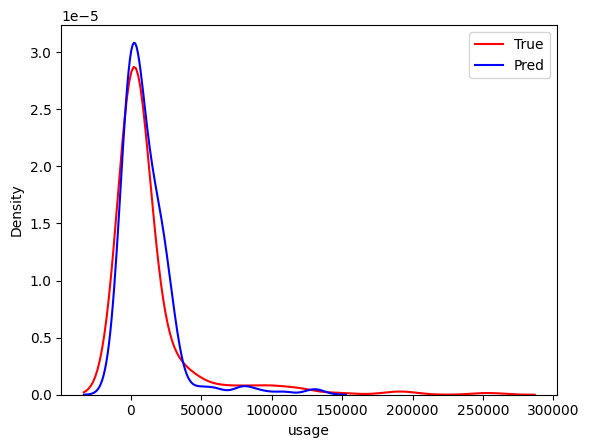

In [304]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.kdeplot(result_standard["y_valid_true"], color="r", label="True")
sns.kdeplot(result_standard["y_valid_pred"], color="b", label="Pred")
plt.legend()

### 데이터 전처리

* https://scikit-learn.org/stable/modules/preprocessing.html#non-linear-transformation

* https://wikidocs.net/87190

* 범주형 변수 전처리: 
  1. Infrequent categories
     * OneHotEncoder: 
     * OrdinalEncoder:
     * LabelEncoder: 
  2. Target Encoder
     * y값이 범주형 변수의 영향을 받을 경우(`city_name` 이나 `routetp`의 경우 괜찮을지도)

* 연속형 변수 전처리:
  1. MaxAbsScaler
  2. MinMaxScaler
      * 매우 다른 스케일의 범위를 0과 1사이로 변환
  3. PowerTransformer: 
      * Box-Cox transformer
  4. QuantileTransformer
  5. RobustScaler
      * 특성들이 같은 스케일을 갖게 되지만 평균대신 중앙값을 사용 ==> 극단값에 영향을 받지 않음
  6. StandardScaler
      * 각 특성의 평균을 0, 분산을 1로 변경하여 모든 특성이 같은 크기를 가지게 함
  7. SplineTransformer

In [22]:
from sklearn.preprocessing import OneHotEncoder, RobustScaler, MinMaxScaler, StandardScaler